# Cilj: Izvući ivice iz date slike koristeći Canny algoritam.

Trebaće nam PILLOW biblioteka za prikazivanje i učitavanje slika, numpy za nizove i scipy.ndimage za neke operacije na slikama

In [ ]:
from PIL import Image,ImageFilter,ImageOps
import numpy as np
import math
from scipy import ndimage
from matplotlib import pyplot as plt
filename = input()

/guster.jpg


Sledeća funkcija služi da odredi određene niske i visoke threshold vrednosti kojima ćemo filtrirati kasnije. To radi Otsuovom metodom u koju neću zalaziti, a threshold vrednosti će biti objašnjene kasnije.

In [ ]:
def compute_otsu_criteria(im, th):
    # create the thresholded image
    thresholded_im = np.zeros(im.shape)
    thresholded_im[im >= th] = 1

    # compute weights
    nb_pixels = im.size
    nb_pixels1 = np.count_nonzero(thresholded_im)
    weight1 = nb_pixels1 / nb_pixels
    weight0 = 1 - weight1

    # if one of the classes is empty, eg all pixels are below or above the threshold, that threshold will not be considered
    # in the search for the best threshold
    if weight1 == 0 or weight0 == 0:
        return np.inf

    # find all pixels belonging to each class
    val_pixels1 = im[thresholded_im == 1]
    val_pixels0 = im[thresholded_im == 0]

    # compute variance of these classes
    var1 = np.var(val_pixels1) if len(val_pixels1) > 0 else 0
    var0 = np.var(val_pixels0) if len(val_pixels0) > 0 else 0

    return weight0 * var0 + weight1 * var1

Sada određujemo Sobel kernel-e koji će nam služiti za traženje gradijenta (prelaza) po X i Y osi. Napominjem da se u nekim implementacijama koriste veći (naime 5x5) Sobel kerneli radi smanjivanja šuma na izlazu, ali iz mog iskustva rezultat ispadne bolji sa standardnim 3x3 kernelom.

In [ ]:
sobelKernelX = np.array([[1, 0, -1], 
                         [2, 0, -2], 
                         [1, 0, -1]])

sobelKernelY = np.array([[ 1,  2,  1],
                         [ 0,  0,  0],
                         [-1, -2, -1]])

Prvi korak Canny algoritma podrazumeva primenu blur filtera (pomućenje slike). Ovo radimo kako bismo izbacili visokofrekventni šum iz slike. Naime, ivice naše slike će ostati prilično "jake" i nakon blur-a, ali jaki prelazi pod uticajem šuma će nestati. 

Takođe prebacujemo sliku u crno-belo radi podjednostavljanja ostatka procesa.

U zavisnosti od slike, ako nismo zadovoljni rezultatom, možemo promeniti jačinu filtera.

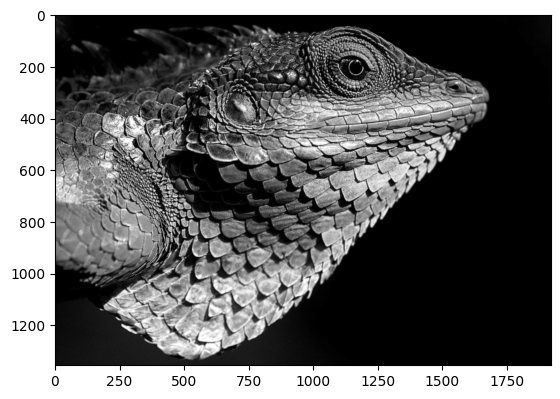

In [ ]:
with Image.open(filename) as img:
    img = ImageOps.grayscale(img)
    img = np.array(img).astype(np.float32)
    img = ndimage.gaussian_filter(img, sigma=1)
    plt.imshow(img, cmap="gray")

Potom koristimo Otsu metodu radi određivanja threshold vrednosti, na šta ćemo se vratiti.

In [ ]:
    threshold_range = range(np.max(img).astype(int)+1)
    criterias = [compute_otsu_criteria(img, th) for th in threshold_range]

    best_threshold = threshold_range[np.argmin(criterias)]
    LOW_THRESHOLD = 2*best_threshold/3
    HIGH_THRESHOLD = best_threshold

### Zatim primenjujemo Sobel kernele na našu sliku konvolucijom. Dobijamo dve slike, jednu sa ivicama po X, a drugu po Y osi.

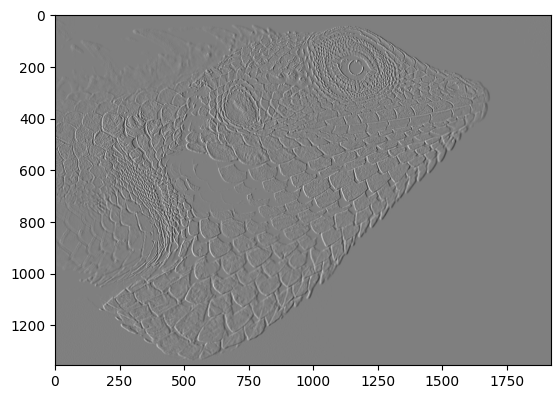

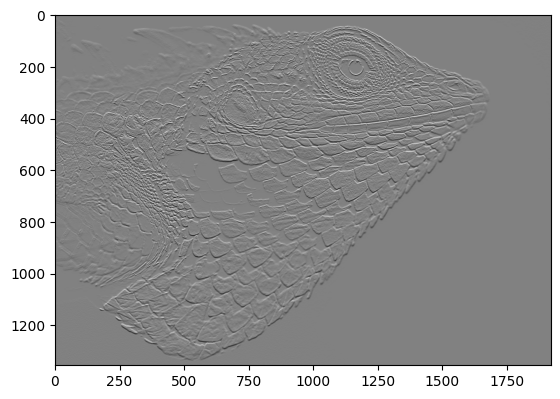

In [ ]:
    XGradient = ndimage.convolve(img, sobelKernelX).astype(np.float32)
    YGradient = ndimage.convolve(img, sobelKernelY).astype(np.float32)
    plt.imshow(XGradient, cmap="gray")
    plt.show()
    plt.imshow(YGradient, cmap="gray")
    plt.show()

### Nakon toga, iz zadatih vrednosti računamo vektor gradijenta tj. prelaza kombinacijom ove dve slike. Preciznije, intenzitet vektora biće određena Pitagorinom teoremom, a ugao arctan funkcijom.

Ugao zaokrugljujemo na 0, 45, 90 ili 135 stepeni jer ćemo ubuduće sa uglom raditi samo na "piksel po piksel" bazi. Preciznije metode koriste originalni ugao i primenjuju interpolaciju u narednim koracima, ali u to neću zalaziti.

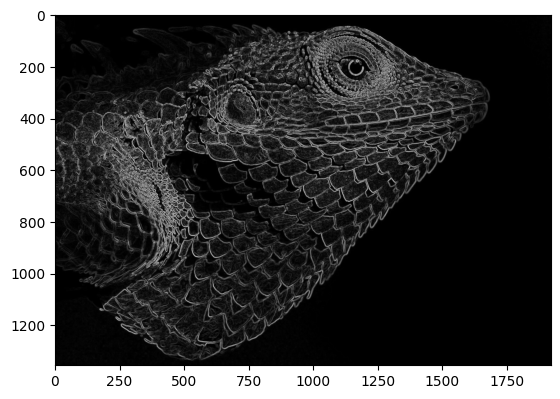

In [ ]:
    Gradient = XGradient.copy()
    Tau = Gradient.copy()

    for i in range(XGradient.shape[0]):
        for j in range(XGradient.shape[1]):
            Gradient[i][j] = np.hypot(XGradient[i][j], YGradient[i][j])
            Tau[i][j] = abs(np.arctan2(XGradient[i][j], YGradient[i][j]))
            if((Tau[i][j] >= 0 and Tau[i][j] < math.pi/8) or (Tau[i][j] >= 7*math.pi/8 and Tau[i][j] < math.pi)):
                Tau[i][j] = 0
            elif(Tau[i][j] >= math.pi/8 and Tau[i][j] < 3*math.pi/8):
                Tau[i][j] = math.pi/4 
            elif(Tau[i][j] >= 3*math.pi/8 and Tau[i][j] < 5*math.pi/8):
                Tau[i][j] = math.pi/2
            elif(Tau[i][j] >= 5*math.pi/8 and Tau[i][j] < 7*math.pi/8):
                Tau[i][j] = 3*math.pi/4
    plt.imshow(Gradient, cmap="gray")
    plt.show()

### Nakon toga, želimo da "stanjimo" ivice koje smo dobili.

To radimo tako što za svaki piksel proveravamo da li je on lokalni maksimum po pravcu prostiranja gradijenta date ivice. Pravac prostiranja gradijenta ivice jeste ugao normalan na pravac prostiranja ivice. Po tom uglu gledamo susedne piksele i stavljamo vrednost na nulu ukoliko je neki od njih veći od datog.

Kao što sam rekao, preciznije metode ne bi gledale isključivo susedne piksele već interpolacijom odredili grupu piksela koja se posmatra.

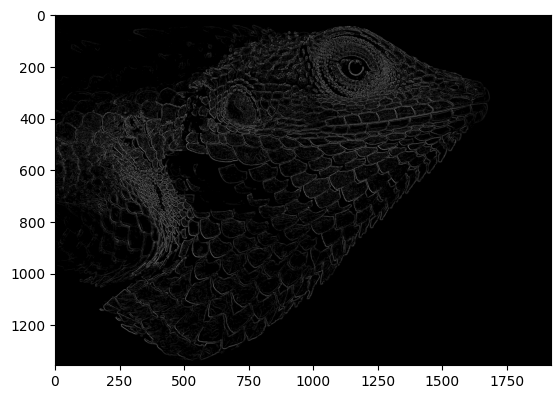

In [ ]:
    for i in range(1,Gradient.shape[0]-1): 
        for j in range(1,Gradient.shape[1]-1):           
            if(Tau[i][j] - 0 < 0.01):
                if(Gradient[i-1][j] > Gradient[i][j] or Gradient[i+1][j] > Gradient[i][j]):
                    Gradient[i][j] = 0
            elif(Tau[i][j] - math.pi/4 < 0.01):
                if(Gradient[i-1][j-1] > Gradient[i][j] or Gradient[i+1][j+1] > Gradient[i][j]):
                    Gradient[i][j] = 0
            elif(Tau[i][j] - math.pi/2 < 0.01):
                if(Gradient[i][j-1] > Gradient[i][j] or Gradient[i][j+1] > Gradient[i][j]):
                    Gradient[i][j] = 0
            elif(Tau[i][j] - 3*math.pi/4 < 0.01):
                 if(Gradient[i-1][j+1] > Gradient[i][j] or Gradient[i+1][j-1] > Gradient[i][j]):
                    Gradient[i][j] = 0
            if(Gradient[i][j] < LOW_THRESHOLD):
                Gradient[i][j] = 0
    plt.imshow(Gradient, cmap="gray")
    plt.show()

Poslednji if u ovoj petlji je deo narednog koraka algoritma tj. da izbacimo sve piksele ispod niskog threshold-a jer za njih znamo da su jako slabi i verovatno šum.

Sledeći korak koristi threshold-e koje smo odredili. Svi pikseli iznad visoke granice smatraju se jakim ivicama, a pikseli između niske i visoke se smatraju slabim ivicama. 

### Slabe ivice koje se ne graniče sa jakim ivicama uklanjamo.

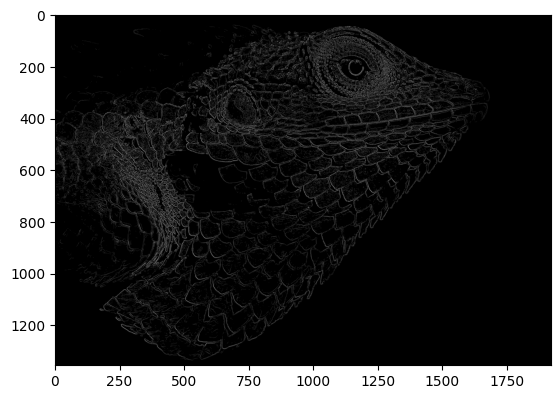

In [ ]:
    for i in range(1,Gradient.shape[0]-1): 
        for j in range(1,Gradient.shape[1]-1):           
            if(Gradient[i][j] > LOW_THRESHOLD and Gradient[i][j] < HIGH_THRESHOLD):
                save = False
                for k in range(-1,1):
                    for l in range(-1,1):
                        if(Gradient[i+k][j+k] > HIGH_THRESHOLD):
                            save = True
                            break
                if(not save):
                    Gradient[i][j] = 0
                    
    plt.imshow(Gradient, cmap="gray")
    plt.show()

## Ovo je konačni rezultat.

### Načini da se unapredi algoritam
Promena blur filtera sa Gaussian blur-a na neki napredniji algoritam može pomoći u očuvanju ivica i ukljanjanju šuma.

Algoritam za određivanje threshold-a automatski nije idealan i bolji rezultati se mogu dobiti nagađanjem i štelovanjem vrednosti, ali nije praktično.

Promena Sobel kernela na 5x5 sam već spomenuo.

Metoda stanjivanja ivica može ostaviti "duple" ivice, postoje složenije metode.